# Parallel Fitting with Astropy Modeling

In the 7.0 release of astropy, a new function was added `parallel_fit_dask`, alongside multiple performance improvement to fitting astropy models with a non-linear fitter. These changes mean that it is now practical to fit many independent models to a large multi-dimensional array of data. In this tutorial we will demonstrate this functionality by fitting many spectra in an observation of the solar chromosphere by the [SPICE](https://spice.ias.u-psud.fr/) instrument on the Solar Orbiter satellite.

In [1]:
%matplotlib widget

In [2]:
from pathlib import Path
import shutil

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling import models as m
from astropy.modeling.fitting import parallel_fit_dask, TRFLSQFitter
from astropy.visualization import imshow_norm, PercentileInterval

from ndcube import NDCube

We are going to use a part of a SPICE observation which is a rastering spectrograph, we are going to use a spectral window containing the Nitrogen IV line at $76.51$ nm and the Neon VIII line at $77.04$ nm.

In [3]:
filename = Path("solo_L2_spice-n-ras_20230415T120519_V02_184549780-000.fits.gz")
window = 'N IV 765 ... Ne VIII 770 (Merged)'

In [4]:
# This code cell will download the lastest version of the data from the archive.
if not filename.exists():
    import urllib.request
    urllib.request.urlretrieve(
        "https://soar.esac.esa.int/soar-sl-tap/data",
        filename=filename,
        data=b'retrieval_type=LAST_PRODUCT&data_item_oid=1446345&product_type=SCIENCE')

We now open the FITS file and access the window via EXTNAME.

In [5]:
hdul = fits.open(filename)
hdu = hdul[window]

The next step is to create an [`NDCube`](https://docs.sunpy.org/projects/ndcube) object from the data we have opened. `NDCube` is a astropy `NDData` subclass designed to manipulate the WCS and data simultaneously.

To construct this `NDCube` object we use the header from the FITS file to make a WCS object, the data and the unit of the data, as well as constructing a mask for all points where the data is NaN.

We then crop down the cube to make it faster to work with.

In [6]:
spice_full = NDCube(hdu.data, wcs=WCS(hdu), unit=hdu.header["BUNIT"], mask=np.isnan(hdu.data))
# The first dimension is length one so let's drop it
spice = spice_full[0]
# We want to make this example finish faster, so let's only do a 100x100 box
spice = spice[:, 100:200, 100:200]

keyword looks very much like CROTAn but isn't. [astropy.wcs.wcs]
Set MJD-OBS to 60049.503702 from DATE-OBS.
Set MJD-BEG to 60049.503702 from DATE-BEG.
Set MJD-AVG to 60049.542980 from DATE-AVG.
Set MJD-END to 60049.582254 from DATE-END'. [astropy.wcs.wcs]


This cube we have constructed has three pixel and four world dimensions, the first array dimension is wavelength (71 long) followed by the slit dimension and then the rastering dimension. The world axes are wavelength, helioprojective latitude and longitude and time which increases along the rastering dimension.

In [7]:
spice

NDCube
------
Dimensions: [ 71. 100. 100.] pix
Physical Types of Axes: [('em.wl',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'time')]
Unit: W / (nm sr m2)
Data Type: >f4

To aid our analysis we are going to make two rebinned cubes from this data, one summed along the wavelength dimension and one of the spectra averaged over all spatial pixels.

In [8]:
wl_sum = spice.rebin((spice.data.shape[0], 1, 1), operation=np.sum)[0]
wl_sum

NDCube
------
Dimensions: [100. 100.] pix
Physical Types of Axes: [('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'time')]
Unit: W / (nm sr m2)
Data Type: float32

In [9]:
spatial_mean = spice.rebin((1, *spice.data.shape[1:]))[:, 0, 0]
spatial_mean

NDCube
------
Dimensions: [71.] pix
Physical Types of Axes: [('em.wl',)]
Unit: W / (nm sr m2)
Data Type: float64

We can now use NDCube's built in plotting helpers to show the spatially averaged spectra, this is using WCSAxes.

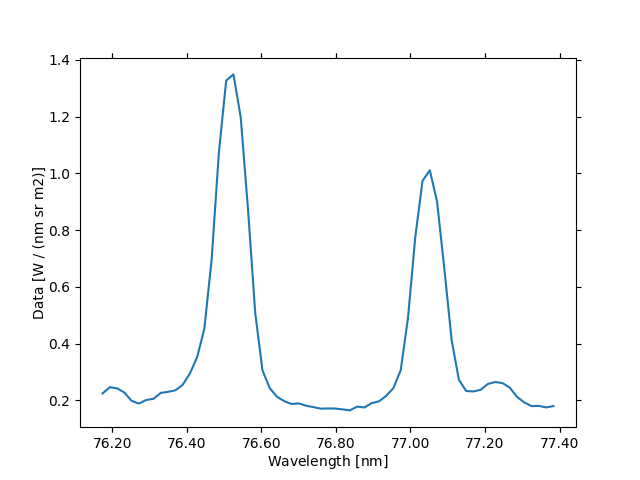

In [10]:
plt.figure()
ax = spatial_mean.plot(axes_units=[u.nm])
ax.coords[0].set_major_formatter("x.xx")

Now we can create a model for this spectra.

In [11]:
NIV_wave = 76.51 * u.nm
NeVIII_wave = 77.04 * u.nm

In [12]:
initial_model = (
    m.Const1D(amplitude=0.1 * spice.unit) +
    m.Gaussian1D(amplitude=1 * spice.unit, mean=NIV_wave, stddev=0.05 * u.nm) +
    m.Gaussian1D(amplitude=1 * spice.unit, mean=NeVIII_wave, stddev=0.05 * u.nm)
)
print(initial_model)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Const1D(amplitude=0.1 W / (nm sr m2))>

    [1]: <Gaussian1D(amplitude=1. W / (nm sr m2), mean=76.51 nm, stddev=0.05 nm)>

    [2]: <Gaussian1D(amplitude=1. W / (nm sr m2), mean=77.04 nm, stddev=0.05 nm)>
Parameters:
     amplitude_0    amplitude_1   mean_1 stddev_1  amplitude_2   mean_2 stddev_2
    W / (nm sr m2) W / (nm sr m2)   nm      nm    W / (nm sr m2)   nm      nm   
    -------------- -------------- ------ -------- -------------- ------ --------
               0.1            1.0  76.51     0.05            1.0  77.04     0.05


To improve our initial conditions we now fit the initial model to the spatially averaged spectra. To do this we use the [`axis_world_coords`](https://docs.sunpy.org/projects/ndcube/en/stable/api/ndcube.NDCube.html#ndcube.NDCube.axis_world_coords) method of `NDCube` which returns all, or a subset of the world coordinates along however many array axes they are correlated with. So in this case we get the wavelength dimension which only returns a single `SpectralCoord` object corresponding to the first array dimension of the cube.

In [44]:
fitter = TRFLSQFitter(calc_uncertainties=True)
average_fit = fitter(
    initial_model,
    spatial_mean.axis_world_coords("em.wl")[0].to(u.nm),
    spatial_mean.data*spatial_mean.unit,
)
print(average_fit)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Const1D(amplitude=0.17179106 W / (nm sr m2))>

    [1]: <Gaussian1D(amplitude=1.20442684 W / (nm sr m2), mean=76.51894524 nm, stddev=0.04247877 nm)>

    [2]: <Gaussian1D(amplitude=0.85726827 W / (nm sr m2), mean=77.04809949 nm, stddev=0.04011449 nm)>
Parameters:
        amplitude_0        amplitude_1     ...       mean_2            stddev_2     
       W / (nm sr m2)     W / (nm sr m2)   ...         nm                 nm        
    ------------------- ------------------ ... ----------------- -------------------
    0.17179106174719638 1.2044268390481165 ... 77.04809949470355 0.04011448531599659


Now we can add to our previous plt the initial model and the model fit to the average spectra.

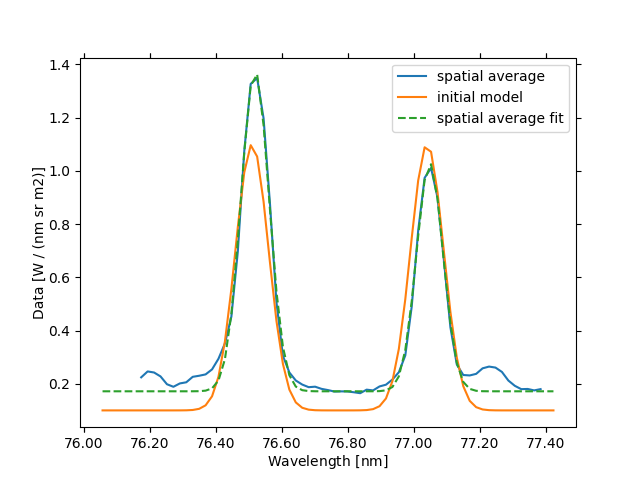

In [14]:
fig = plt.figure()
ax = spatial_mean.plot(label="spatial average")
ax.coords[0].set_format_unit("nm")
ax.coords[0].set_major_formatter("x.xx")
ax.plot(initial_model(spatial_mean.axis_world_coords("em.wl")[0].to(u.AA)), label="initial model")
ax.plot(average_fit(spatial_mean.axis_world_coords("em.wl")[0].to(u.AA)), linestyle="--", label="spatial average fit")
plt.legend()

## Parallel Fitting

Now we have our model to fit to all our spectra we can start working on the parallel fitting.

The function `parallel_fit_dask` will map a model to each element of a cube along one (or more) "fitting axes", in this case our fitting axis is our wavelength axis (array axis 0). So we want to fit each slice of the data array along the 0th axis.

The key arguments to the `parallel_fit_dask` function are:

* A data array. This can be a numpy array or a dask array, or a `NDData` (or subclass like `NDCube`) object. If it's a `NDData` object then the data, wcs, mask, data_unit and uncertainty are all extracted from the `NDData` object and used in place of their respective keyword arguments.
* A model to fit.
* A fitter instance.
* The fitting axis (or axes).

What is returned from `parallel_fit_dask` is a model with array parameters with the shape of the non-fitting axes of the data (so in this case 100x100 arrays).

We can therefore fit all our SPICE cube as follows:

In [15]:
spice_model_fit = parallel_fit_dask(
    data=spice,
    model=average_fit,
    fitter=TRFLSQFitter(),
    fitting_axes=0,
)

Given that we are going to want to visualise the output of a few fits, I am going to define a plotting function which will display the shift in the peak locations of the two Gaussians. We shall talk more about this later.

In [33]:
def plot_spice_fit(spice_model_fit):
    g1_peak_shift = spice_model_fit.mean_1.quantity.to(u.km/u.s, equivalencies=u.doppler_optical(NIV_wave))
    g2_peak_shift = spice_model_fit.mean_2.quantity.to(u.km/u.s, equivalencies=u.doppler_optical(NeVIII_wave))

    fig, axs = plt.subplots(ncols=3, subplot_kw=dict(projection=wl_sum), figsize=(11, 4))
    fig.suptitle(f"SPICE - {hdu.header["EXTNAME"]} - {hdu.header["DATE-AVG"]}")
    
    im = wl_sum.plot(axes=axs[0])
    fig.colorbar(axs[0].get_images()[0], ax=axs[0], extend="both", label=f"{wl_sum.unit:latex}", shrink=0.8)
    axs[0].set_title("Data (summed over wavelength)", pad=40)
    
    g1_max = np.percentile(np.abs(g1_peak_shift.value), 99)
    mean_1 = axs[1].imshow(g1_peak_shift.value, cmap="coolwarm", vmin=-g1_max, vmax=g1_max)
    fig.colorbar(mean_1, ax=axs[1], extend="both", label=f"Velocity from Doppler shift [{g1_peak_shift.unit:latex}]", shrink=0.8)
    axs[1].set_title(f"N IV ({NIV_wave:latex})", pad=40)
    
    g2_max = np.percentile(np.abs(g2_peak_shift.value), 98)
    mean_2 = axs[2].imshow(g2_peak_shift.value, cmap="coolwarm", vmin=-g2_max, vmax=g2_max)
    fig.colorbar(mean_2, ax=axs[2], extend="both", label=f"Velocity from Doppler shift [{g2_peak_shift.unit:latex}]", shrink=0.8)
    axs[2].set_title(f"Ne VIII ({NeVIII_wave:latex})", pad=40)
    
    for ax in axs:
        ax.coords[0].set_ticklabel(exclude_overlapping=True)
        ax.coords[0].set_axislabel("Helioprojective Longitude")
        ax.coords[1].set_axislabel("Helioprojective Latitude")
        ax.coords[2].set_ticklabel(exclude_overlapping=True)
    
    fig.tight_layout()

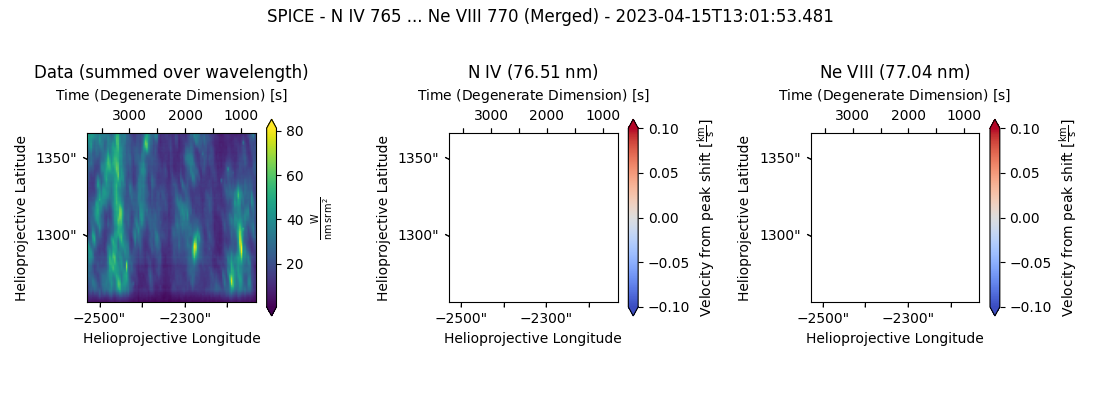

In [25]:
plot_spice_fit(spice_model_fit)

Oh dear! This clearly didn't work.

To discover why we can use the "diagnostics" functionality of the `parallel_fit_dask` function. This lets each process spun up for the parallelism write out logs of errors or warnings to a directory of our choice, or run a function (useful for making diagnostic plots). In this case we are going to have it write out error logs.

First we define the path we want the logs saved to and ensure the directory and the contents of that directory have been removed (to make sure that no output from previous runs is present).

In [26]:
diag_path = Path("./diag")
shutil.rmtree(diag_path, ignore_errors=True)

We pass the `diagnostics="error"` argument to enable logging of error messages and the `diagnostics_path=` argument to specify where to save the logs.

In [27]:
spice_model_fit = parallel_fit_dask(
    data=spice,
    model=average_fit,
    fitter=TRFLSQFitter(),
    fitting_axes=0,
    diagnostics="error",
    diagnostics_path=diag_path,
) 

We can now find all the folders in the diagnostics path:

In [28]:
diag_folders = list(diag_path.glob("*"))

And read the contents of each log into a list.

In [29]:
errors = []
for diag in diag_folders:
    if (path := (diag/"error.log")).exists():
        content = open(path).read()
        errors.append(content)

We can now print out the first error

In [30]:
print(f"{len(errors)} errors occured")
print("First error is:")
print(errors[0])

10000 errors occured
First error is:
Traceback (most recent call last):
  File "/home/stuart/.virtualenvs/astropy-parallel-fitting/lib/python3.12/site-packages/astropy/modeling/_fitting_parallel.py", line 160, in _fit_models_to_chunk
    model_fit = fitter(
                ^^^^^^^
  File "/home/stuart/.virtualenvs/astropy-parallel-fitting/lib/python3.12/site-packages/astropy/modeling/fitting.py", line 303, in wrapper
    return func(self, model, x, y, z=z, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/stuart/.virtualenvs/astropy-parallel-fitting/lib/python3.12/site-packages/astropy/modeling/fitting.py", line 1434, in __call__
    init_values, fitparams, cov_x = self._run_fitter(
                                    ^^^^^^^^^^^^^^^^^
  File "/home/stuart/.virtualenvs/astropy-parallel-fitting/lib/python3.12/site-packages/astropy/modeling/fitting.py", line 1608, in _run_fitter
    self.fit_info = optimize.least_squares(
                    ^^^^^^^^^^^^^^^^^^^^^^

The reason for the faliure of the fitting was the presence of NaN values in the data array. When calling the [`TRFLSQFitter`](https://docs.astropy.org/en/stable/api/astropy.modeling.fitting.TRFLSQFitter.html) (and many others) it's possible to set the [`filter_non_finite=True`](https://docs.astropy.org/en/stable/api/astropy.modeling.fitting.TRFLSQFitter.html#astropy.modeling.fitting.TRFLSQFitter.__call__) keyword argument. To do this with the `parallel_fit_dask` function we pass a dictionary of keyword arguments to the fitter as the `fitter_kwargs` argument:

In [34]:
spice_model_fit = parallel_fit_dask(
    data=spice,
    model=average_fit,
    fitter=TRFLSQFitter(),
    fitting_axes=0,
    fitter_kwargs={"filter_non_finite": True}, # Filter out non-finite values,
) 

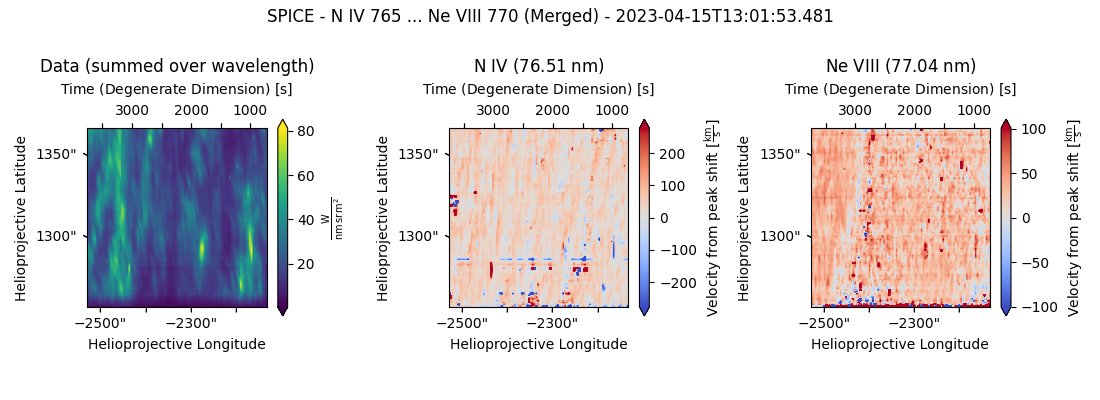

In [35]:
plot_spice_fit(spice_model_fit)

That's better!

## Working with the fit

The return value of the `parallel_fit_dask` function is a Astropy model instance with the parameters set based on the result of the fit. This is the same as the return value of the fitter called in serial, so for more information about how to work with the results of the fit, you can read the Astropy documentation for serial fitting, such as this page on [Fitting Models to Data](https://docs.astropy.org/en/stable/modeling/fitting.html).

We shall quickly cover some key points.

Our input model is a "CompoundModel" which is a model that combines many models together via various operators, in our case the `+` operator. Each individual model can be accessed by using slicing notation, if we print out our model we can see that we have three models 0, 1 and 2 all added together.

In [36]:
print(spice_model_fit)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Const1D(amplitude=[[0.06322513, 0.07065124, 0.06473374, ..., 0.05360816, 0.06640315, 0.04327178], [0.05331346, 0.08086215, 0.09070434, ..., 0.05204279, 0.03990928, 0.04085817], [0.06496832, 0.0888655 , 0.10970875, ..., 0.07866786, 0.05543009, 0.04633769], ..., [0.46005175, 0.37344314, 0.37365794, ..., 0.20420147, 0.25743732, 0.19960165], [0.44216156, 0.36566345, 0.36117901, ..., 0.21320554, 0.28267282, 0.18471561], [0.42033637, 0.35444952, 0.35541832, ..., 0.22849339, 0.31909455, 0.17743556]] W / (nm sr m2))>

    [1]: <Gaussian1D(amplitude=[[-0.00170426,  0.05422677,  0.07591212, ...,  0.05380147,  0.06394041, 0.02023163], [ 0.08178623,  0.13955865,  0.19369281, ...,  0.19118573,  0.14752885, 0.05792925], [ 0.06686854,  0.17941652,  0.32976375, ...,  0.28197502,  0.16263158, 0.1239208 ], ..., [ 2.83641351,  1.66155343,  1.6257359 , ...,  1.40866253,  2.12815706, 0.7

To access the first Gaussian model we can do this:

In [37]:
print(spice_model_fit[1])

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
                     amplitude                  ...
                   W / (nm sr m2)               ...
    ------------------------------------------- ...
    -0.001704264049756432 .. 0.6991797939639081 ...


If we want to access the parameters of this model we can do it in two different ways:

In [38]:
print(spice_model_fit[1].mean)

Parameter('mean', value=[[7.65134384e-08 7.65196463e-08 7.65167012e-08 ... 7.65187768e-08
  7.64633001e-08 7.62861771e-08]
 [7.65368931e-08 7.65123707e-08 7.65260937e-08 ... 7.65043756e-08
  7.65292446e-08 7.64724933e-08]
 [7.65362001e-08 7.65309555e-08 7.65240368e-08 ... 7.65197368e-08
  7.65240551e-08 7.65214701e-08]
 ...
 [7.65132091e-08 7.65230464e-08 7.65180193e-08 ... 7.65147190e-08
  7.65089970e-08 7.65240991e-08]
 [7.65193051e-08 7.65254962e-08 7.65271516e-08 ... 7.65179377e-08
  7.65107631e-08 7.65353972e-08]
 [7.65191335e-08 7.65231942e-08 7.65247531e-08 ... 7.65217862e-08
  7.65138491e-08 7.65254721e-08]], unit=m)


In [39]:
print(spice_model_fit.mean_1)

Parameter('mean', value=[[7.65134384e-08 7.65196463e-08 7.65167012e-08 ... 7.65187768e-08
  7.64633001e-08 7.62861771e-08]
 [7.65368931e-08 7.65123707e-08 7.65260937e-08 ... 7.65043756e-08
  7.65292446e-08 7.64724933e-08]
 [7.65362001e-08 7.65309555e-08 7.65240368e-08 ... 7.65197368e-08
  7.65240551e-08 7.65214701e-08]
 ...
 [7.65132091e-08 7.65230464e-08 7.65180193e-08 ... 7.65147190e-08
  7.65089970e-08 7.65240991e-08]
 [7.65193051e-08 7.65254962e-08 7.65271516e-08 ... 7.65179377e-08
  7.65107631e-08 7.65353972e-08]
 [7.65191335e-08 7.65231942e-08 7.65247531e-08 ... 7.65217862e-08
  7.65138491e-08 7.65254721e-08]], unit=m)


In our plotting helper above we access the mean parameters of both the Gaussian fits, let's take a closer look at that.
The parameters on a model are `Parameter` classes, but they can be converted to `Quantity` objects by accessing their `.quantity` property:

In [47]:
spice_model_fit.mean_1.quantity

<Quantity [[7.65134384e-08, 7.65196463e-08, 7.65167012e-08, ...,
            7.65187768e-08, 7.64633001e-08, 7.62861771e-08],
           [7.65368931e-08, 7.65123707e-08, 7.65260937e-08, ...,
            7.65043756e-08, 7.65292446e-08, 7.64724933e-08],
           [7.65362001e-08, 7.65309555e-08, 7.65240368e-08, ...,
            7.65197368e-08, 7.65240551e-08, 7.65214701e-08],
           ...,
           [7.65132091e-08, 7.65230464e-08, 7.65180193e-08, ...,
            7.65147190e-08, 7.65089970e-08, 7.65240991e-08],
           [7.65193051e-08, 7.65254962e-08, 7.65271516e-08, ...,
            7.65179377e-08, 7.65107631e-08, 7.65353972e-08],
           [7.65191335e-08, 7.65231942e-08, 7.65247531e-08, ...,
            7.65217862e-08, 7.65138491e-08, 7.65254721e-08]] m>

A `Quantity` object can be converted to other units:

In [48]:
spice_model_fit.mean_1.quantity.to(u.AA)

<Quantity [[765.13438352, 765.19646298, 765.16701224, ..., 765.18776843,
            764.63300141, 762.86177083],
           [765.36893133, 765.12370698, 765.26093745, ..., 765.04375572,
            765.29244551, 764.72493268],
           [765.36200091, 765.30955549, 765.24036763, ..., 765.19736758,
            765.24055057, 765.21470086],
           ...,
           [765.1320911 , 765.23046431, 765.18019252, ..., 765.1471904 ,
            765.08997047, 765.24099097],
           [765.19305062, 765.25496159, 765.27151633, ..., 765.17937726,
            765.10763054, 765.35397162],
           [765.19133467, 765.23194192, 765.24753122, ..., 765.21786166,
            765.13849054, 765.2547215 ]] Angstrom>

Using [equivalencies](https://docs.astropy.org/en/stable/units/equivalencies.html) you can do unit conversions which require an assumption or some extra calculation. Some of the built-in equivalencies in Astropy are for doppler shifts, we can use the `doppler_optical` equivalency to convert to velocity.

In [49]:
spice_model_fit.mean_1.quantity.to(u.km/u.s, equivalencies=u.doppler_optical(NIV_wave))

<Quantity [[  13.47264458,   37.79750785,   26.25769564, ...,
              34.39068611, -182.98608538, -877.01506079],
           [ 105.3765314 ,    9.2892086 ,   63.06082114, ...,
             -22.03844106,   75.40676158, -146.96425904],
           [ 102.66095419,   82.11103915,   55.00085819, ...,
              38.15196394,   55.07253992,   44.943736  ],
           ...,
           [  12.57439533,   51.12039918,   31.42218235, ...,
              18.49082029,   -3.9299156 ,   55.24510289],
           [  36.46042811,   60.71927226,   67.20598834, ...,
              31.10273594,    2.98990708,   99.51480207],
           [  35.78806195,   51.69937673,   57.80779726, ...,
              46.18224563,   15.08191686,   60.62519611]] km / s>

One other thing we may want to do is to evaluate the fitted model for all pixels, for example to plot them or otherwise inspect a single fit.
This can be done by passing in a wavelength array which is [broadcastable](https://numpy.org/doc/stable/user/basics.broadcasting.html) to the shape of the non-fitting axes. We can do this by once again using the `axis_world_coords` method of `NDCube`. 

In [ ]:
wavelength = spatial_mean.axis_world_coords("em.wl")[0]

In [ ]:
wavelength.shape

and then to make it the correct shape we can add two dummy dimensions to the end:

In [ ]:
wavelength = wavelength[:, None, None]

In [ ]:
wavelength.shape

We can now evaulate the model for all spatial points with this input:

In [ ]:
all_fits = spice_model_fit(wavelength)

We can now make a plot of all the fits.

In [ ]:
fig = plt.figure(figsize=(11, 5))

ax = spatial_mean.plot(axes_units=[u.nm], label="Average spectra", zorder=99)
ax.coords["wavelength"].set_major_formatter("x.xx")

ax.plot(average_fit(wave), linestyle="--", label="Spatial Average Model", zorder=99)

# Iterate over each fit and plot it.
for fit_arr in all_fits.reshape((spatial_mean.data.shape[0], -1)).T:
    line, = ax.plot(fit_arr, alpha=0.3, color="C3", linewidth=0.05)

# Use the last line plotted as the anchor for the legend
line.set_label("Fitted Pixels")
leg = plt.legend(loc="upper left")
# Make the legend not semi-transparent
for lh in leg.legend_handles:
    lh.set_alpha(1)